In [ ]:
import sys, os, math
sys.path.append('..')  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from src.mc_pricer import (
    bs_price, mc_price_bs, mc_greeks_finite_differences, mc_greeks_pathwise,
    mc_greeks_lr, mc_all_greeks, price_option_heston, price_option_sabr_via_hagan
)
from src.heston_model import heston_simulate_full_truncation, mc_price_heston
from src.sabr_model import sabr_simulate, hagan_sabr_implied_vol
from src.exotics import mc_price_asian, mc_price_barrier, mc_greeks_exotic_finite_diff
from src.utils import fetch_spot_history

Imports OK - start demo


In [ ]:
# Section 1 — Black-Scholes analytic vs Monte Carlo under GBM
ser = fetch_spot_history('AAPL', period='2y')
S0 = float(ser.iloc[-1])

K = 284.15
r = 0.037
sigma = 0.2786
T = 0.1190  # ~30 days

bs = bs_price(S0, K, r, sigma, T, option='call')
print('Black-Scholes price (analytic):', bs)

price_mc, se_mc, _ = mc_price_bs(S0, K, r, sigma, T, n_sims=200000, option='call', seed=42)
print('MC price (GBM):', price_mc, 'SE:', se_mc)
print('Difference (MC - BS):', price_mc - bs)

Black-Scholes price (analytic): 11.502085888257653
MC price (GBM): 11.527908275149516 SE: 0.0388635182851879
Difference (MC - BS): 0.025822386891862337


In [4]:
# Section 2 — Greeks demonstration (finite-diff, pathwise, LR)
n_sims = 100000
res_all = mc_all_greeks(S0, K, r, sigma, T, n_sims=n_sims, option='call', seed=42)
print('\nFinite differences:')
pprint(res_all['finite'])
print('\nPathwise:')
pprint({k: v for k, v in res_all['pathwise'].items() if 'price' in k or 'delta' in k or 'vega' in k or 'theta' in k})
print('\nLikelihood ratio:')
pprint({k: v for k, v in res_all['lr'].items() if 'price' in k or 'delta' in k or 'vega' in k or 'theta' in k})


Finite differences:
{'delta': 0.5373816499207429,
 'gamma': 0.013847135296174429,
 'price': 11.516768777900934,
 'price_se': 0.05488258530989369,
 'theta': -50.880434532490916,
 'vega': 39.00066346901099}

Pathwise:
{'delta_pw': 0.5373881088861308,
 'delta_pw_se': 0.0017087127092955258,
 'price': 11.516768777900934,
 'price_se': 0.05488258530989369,
 'theta_pw': 50.877392047438754,
 'theta_pw_se': 0.24914215604763018,
 'vega_pw': 39.00061043119107,
 'vega_pw_se': 0.20397244865860129}

Likelihood ratio:
{'delta_lr': 0.5404062593093251,
 'delta_lr_se': 0.003962883231188203,
 'price': 11.516768777900934,
 'price_se': 0.05488258530989369,
 'theta_lr': 51.76144804098693,
 'theta_lr_se': 0.9331028263589174,
 'vega_lr': 39.728726853745286,
 'vega_lr_se': 0.7666628439457543}


In [5]:
# Section 3 — Heston MC pricing example
kappa = 1.2
theta_v = 0.06
xi = 0.5
rho = -0.6
v0 = sigma ** 2

price_heston, se_heston, discounted, S_T = mc_price_heston(S0, K, r, kappa, theta_v, xi, rho, v0, T,
                                                           steps=252, n_paths=60000, option='call', rng_seed=42)
print('Heston MC price:', price_heston, 'SE:', se_heston)
print('BS price (sqrt(theta_v)) as rough comparator:', bs_price(S0, K, r, math.sqrt(theta_v), T, option='call'))

Heston MC price: 8.591558661371602 SE: 0.05441310284893991
BS price (sqrt(theta_v)) as rough comparator: 10.191963890608093


In [6]:
# Section 4 — SABR Hagan implied vol and price via Black
alpha = 0.25
beta = 0.9
rho_sabr = -0.3
nu = 0.5

F = S0 * math.exp(r * T)
iv = hagan_sabr_implied_vol(F, K, T, alpha, beta, rho_sabr, nu)
price_sabr, iv_returned = price_option_sabr_via_hagan(S0, K, r, T, alpha, beta, rho_sabr, nu, option='call')
print('Hagan SABR IV:', iv)
print('Price via SABR->Black:', price_sabr)

Hagan SABR IV: 0.14262521078507387
Price via SABR->Black: 6.210975970289837


In [7]:
# Section 5 — Exotics: Asian and Barrier
# Asian (arithmetic) under GBM
price_asian_bs, se_asian_bs = mc_price_asian(S0, K, r, sigma, T, steps=30, n_paths=80000,
                                            option='call', avg_type='arithmetic', model='bs', seed=42, batch_size=40000)
print('Asian (GBM) price:', price_asian_bs, 'SE:', se_asian_bs)

# Asian under Heston
heston_params = {'kappa': kappa, 'theta': theta_v, 'xi': xi, 'rho': rho, 'v0': v0}
price_asian_h, se_asian_h = mc_price_asian(S0, K, r, sigma, T, steps=30, n_paths=40000,
                                          option='call', avg_type='arithmetic', model='heston',
                                          heston_params=heston_params, seed=42, batch_size=20000)
print('Asian (Heston) price:', price_asian_h, 'SE:', se_asian_h)

# Barrier (up-and-out) under GBM
H = S0 * 1.2
price_barrier_bs, se_barrier_bs = mc_price_barrier(S0, K, r, sigma, T, steps=252, n_paths=60000,
                                                   barrier=H, barrier_type='up-and-out', option='call',
                                                   model='bs', seed=42, batch_size=30000)
print('Barrier (GBM) price:', price_barrier_bs, 'SE:', se_barrier_bs)

# Barrier under Heston
price_barrier_h, se_barrier_h = mc_price_barrier(S0, K, r, sigma, T, steps=252, n_paths=40000,
                                                 barrier=H, barrier_type='up-and-out', option='call',
                                                 model='heston', heston_params=heston_params, seed=42, batch_size=20000)
print('Barrier (Heston) price:', price_barrier_h, 'SE:', se_barrier_h)

Asian (GBM) price: 6.731488716197842 SE: 0.035372267796884585
Asian (Heston) price: 5.2688467875333 SE: 0.040586879511108585
Barrier (GBM) price: 8.434626528373379 SE: 0.05257777313116074
Barrier (Heston) price: 7.876700030224566 SE: 0.0606011719999931


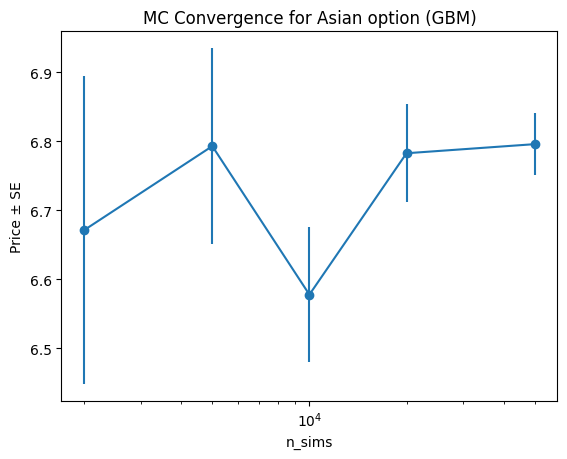

In [ ]:
# Section 6 — Convergence diagnostics (Asian GBM)
n_list = [2000, 5000, 10000, 20000, 50000]
prices = []
SEs = []
for n in n_list:
    p, se = mc_price_asian(S0, K, r, sigma, T, steps=30, n_paths=n,
                           option='call', avg_type='arithmetic', model='bs', seed=42, batch_size=20000)
    prices.append(p)
    SEs.append(se)

plt.errorbar(n_list, prices, yerr=SEs, fmt='o-')
plt.xscale('log')
plt.xlabel('n_sims')
plt.ylabel('Price ± SE')
plt.title('MC Convergence for Asian option (GBM)')
plt.show()

In [ ]:
# Section 7 — Unit tests / sanity checks
price_mc, se_mc, _ = mc_price_bs(100, 100, 0.01, 0.2, 30/252, n_sims=50000, option='call', seed=123)
price_bs = bs_price(100, 100, 0.01, 0.2, 30/252, option='call')
print('Price MC vs BS:', price_mc, price_bs, 'SE:', se_mc)
assert abs(price_mc - price_bs) < 6 * se_mc, "MC price vs BS outside tolerance"

pw = mc_greeks_pathwise(100, 100, 0.01, 0.2, 30/252, n_sims=80000, option='call', seed=42)
fd = mc_greeks_finite_differences(100, 100, 0.01, 0.2, 30/252, n_sims=80000, option='call', seed=42)
print('Pathwise delta:', pw['delta_pw'], 'Finite diff delta:', fd['delta'])

Price MC vs BS: 2.810916889748419 2.8106773469827786 SE: 0.01896190474896223
Pathwise delta: 0.5202389618485657 Finite diff delta: 0.5202242737790019
